## Bibliotecas

In [294]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread,imsave,imshow
from skimage.color import rgb2gray
from skimage import color
from scipy.stats import norm, kurtosis, entropy, skew
from skimage.feature import graycoprops,graycomatrix
import cv2
from glob import glob
import os
import csv
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score as acc
import math
import random
from tqdm import tqdm
from skimage.transform import resize
from skimage import img_as_ubyte, img_as_uint

## Geração de Valores Aleatórios

In [212]:
def geraNum(n, tipo='i'):
    resultado = []
    for i in range(n):
        if tipo == 'i':
            resultado.append(random.randint(0, 100))
        else:
            resultado.append(round(random.uniform(0, 1), 3))
    return sorted(resultado)

def geraValoresRandom():
    k = geraNum(4)
    e = [1.0,1.5,2.0,3.0]
    c = geraNum(4)
    gama = geraNum(4, 'f')
    return k, e, c, gama, {'k': k, 'e': e, 'c': c, 'gama': gama}


In [213]:
k, e, c, gama, valRandom = geraValoresRandom()

In [214]:
for i in [k, e, c, gama, valRandom]:
    print(i)

[7, 75, 77, 88]
[1.0, 1.5, 2.0, 3]
[31, 38, 46, 91]
[0.273, 0.355, 0.414, 0.576]
{'k': [7, 75, 77, 88], 'e': [1.0, 1.5, 2.0, 3], 'c': [31, 38, 46, 91], 'gama': [0.273, 0.355, 0.414, 0.576]}


## Fórmulas

### Alongamento:

Fórmula - 4 testes:
    $$ s = T(r) = \frac{1}{1 + \frac{k}{r}^{E} }  $$
<ul>
    <li> k é a constante de alongamento</li>
    <li> E é o expoente de alongamento</li>
    <li> r é o pixel calculado em questão</li>
</ul>

In [5]:
def alongamento(k, r, e):
    return 1 / ( 1 + ( ( k / r ) ** e ) )

### Negativo:

Fórmula - 1 teste:
    $$s = L - 1 - r$$

In [6]:
def negativo(r, l=255):
    return l - 1 - r

### Logarítmico:

Fórmula - 4 testes:
    $$s = c\log(1+r)$$

In [7]:
def logaritmico(r, c):
    return c * math.log(1 + r)

### Potência:

Fórmula - 4 Testes:
    $$s = cr^{\gamma}$$

In [8]:
def potencia(c, r, gama):
    return c * (r ** gama)

## Imagens: Funções Básica 
- Leitura
- Apresentação
- Salvar

### Leitura

In [9]:
# resolução das imagens
altura = 240
largura = 240

In [327]:
def Ler_Cinza(imagem):
    # Função para realizar a leitura de uma imagem e retornar a imagem cinza.
    img = imread(imagem)
    #red = cv2.resize(img, (largura, altura))
    red2 = resize(img, (largura, altura))
    return img, red2, rgb2gray(red2)

In [275]:
img, img_red, img_bw = Ler_Cinza('../Atividade-03/flowers/daisy/10172379554_b296050f82_n.jpg')

### Apresentação

In [13]:
def manyShow(*imgs, color=None):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20),sharex=True)
    for index, i in enumerate(ax):
        i.imshow(imgs[index], cmap=color)
        i.set_title(f'{imgs[index].shape}')
        i.axis('off')

In [14]:
def manyShowWithTitle(*imgs, color=None):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20),sharex=True)
    for index, i in enumerate(ax):
        i.imshow(imgs[index]['img'], cmap=color)
        i.set_title(f'{imgs[index]["title"]} \n {imgs[index]["img"].shape}')
        i.axis('off')

In [251]:
def showAplicadas(img_red, img_bw, nova_alon, nova_neg, nova_log, nova_pot):
    manyShowWithTitle(
        {'img': img_red, 'title': f'Original'},
        {'img': img_bw, 'title': f'Imagem b&w'},
        {'img': nova_alon, 'title': f'Alogamento'},
        {'img': nova_neg, 'title': f'Negativo'},
        {'img': nova_log, 'title': f'Logarico'},
        {'img': nova_pot, 'title': f'Potencia'},
        color='gray'
    )

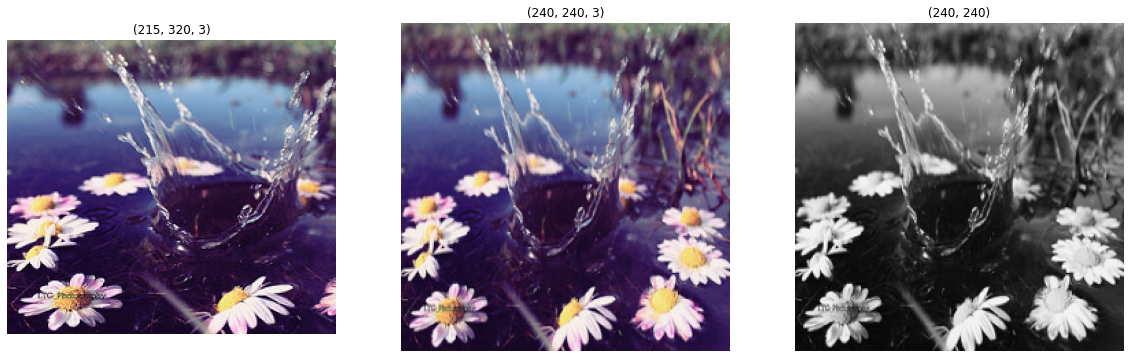

In [280]:
manyShow(img, img_red, img_bw, color='gray')

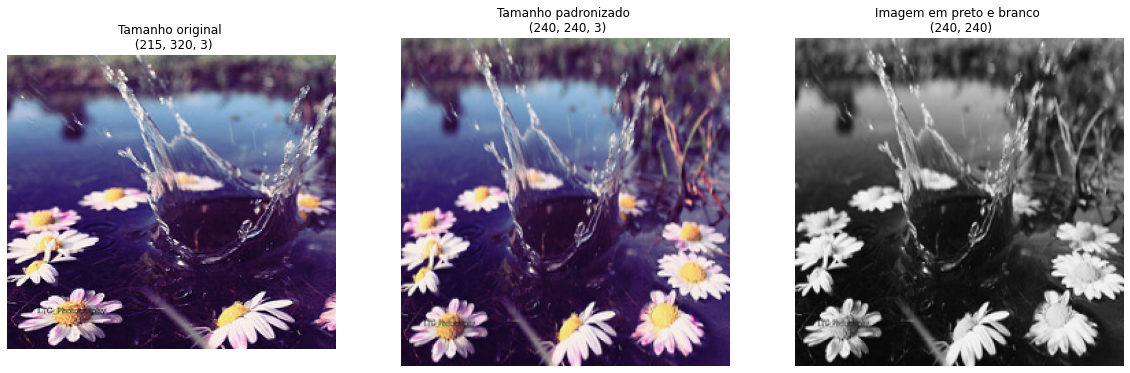

In [18]:
manyShowWithTitle(
        {'img': img, 'title': f'Tamanho original'},
        {'img': img_red, 'title': f'Tamanho padronizado'},
        {'img': img_bw, 'title': f'Imagem em preto e branco'},
        color='gray')

### Salvar

In [310]:
def salvaImg(pasta, img, nome):
    if not os.path.exists(pasta):
        os.mkdir(pasta)
    plt.imsave(pasta+nome+'.png', img, cmap=plt.cm.gray)

## DataSet
- Criação das pastas para o novo DataSet
- Leitura de um DataSet

### Criação das Pastas

In [123]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
formulas = ['alongamento', 'negativo', 'logaritmico', 'potencia']

In [129]:
def criaPastas():
    for index, i in enumerate(formulas):
        os.mkdir(f'./dataset/{i}')
    
    for i in formulas:
        for j in range(4):
            if i == 'negativo' and j > 0:
                break
            else:
                os.mkdir(f'./dataset/{i}/teste_{j+1}')

        if i == 'alongamento':
            for j in range(2):
                os.mkdir(f'./dataset/{i}/teste_{4 + j + 1}')

    dataset = glob(f'./dataset/*/*', recursive=True)

    for i in tqdm(dataset):
        for j in classes:
            os.mkdir(f'{i}/{j}')

In [130]:
# Comentar para não criar as pastas novamente
# criaPastas()

100%|██████████| 15/15 [00:00<00:00, 11432.77it/s]


In [89]:
novo_dataset = glob(f'./dataset/*/*/*', recursive=True)

### Leitura de um DataSet

#### DataSet Original

In [22]:
def contabilizaTamanhos(dataset):
    tamanhos = {'total': 0}
    for classe in dataset:
        tamanhos[classe] = len(dataset[classe])
        tamanhos['total'] += len(dataset[classe])
    dataset['tamanhos'] = tamanhos
    return dataset

In [23]:
def lerDataset(nameDataset, classes, endereco='flowers'):
    dataset = {}
    for classe in classes:
        dataset[classe] = glob(f'{endereco}/{classe}/*', recursive=True)

    dataset = contabilizaTamanhos(dataset)
    
    return dataset

In [88]:
dataset = lerDataset('dataset', classes, f'../Atividade-03/flowers')
dataset.keys()

dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip', 'tamanhos'])

#### DataSet Novo

In [107]:
d_novo = {
    'alongamento': glob(f'./dataset/alongamento/*', recursive=True),
    'negativo': glob(f'./dataset/negativo/*', recursive=True),
    'logaritmico': glob(f'./dataset/logaritmico/*', recursive=True),
    'potencia': glob(f'./dataset/potencia/*', recursive=True)
}

## Nova Base de Imagens

### Funções

In [216]:
def selecionaFucao(formula, r, c, k, e, gama):
    if formula == 'alongamento':
        resultado = alongamento(k, r, e)
    elif formula == 'negativo':
        resultado = negativo(r)
    elif formula == 'logaritmico':
        resultado = logaritmico(r, c)
    else:
        resultado = potencia(c, r, gama)
    return resultado

In [222]:
def criaNovaImagem(formula, imagem, c, k, e, gama):
    nova_img = imagem.copy()
    largura, altura = imagem.shape
    for i in range(largura):
        for j in range(altura):
            nova_img[i, j] = selecionaFucao(formula, imagem[i, j], c, k, e, gama)
    return nova_img

In [318]:
def montaImagens(dataset, classe, pasta, formula, c, k, e, gama):
    for i in tqdm(dataset[classe], desc=f'{formula}: '):
        img, img_red, img_bw = Ler_Cinza(i)
        nome = i.split('/')[-1]
        nova_img = criaNovaImagem(formula, img_bw, c, k, e, gama)
        salvaImg(pasta, nova_img, nome)

### Testes

In [331]:
img2, img_red2, img_bw2 = Ler_Cinza(dataset['daisy'][0])
nova_alon = criaNovaImagem('alongamento', img_bw2, 0, k[0], e[0], 0)
nova_neg = criaNovaImagem('negativo', img_bw2, 0, 0, 0, 0)
nova_log = criaNovaImagem('logaritmico', img_bw2, c[2], 0, 0, 0)
nova_pot = criaNovaImagem('potencia', img_bw2, c[0], 0, 0, gama[0])

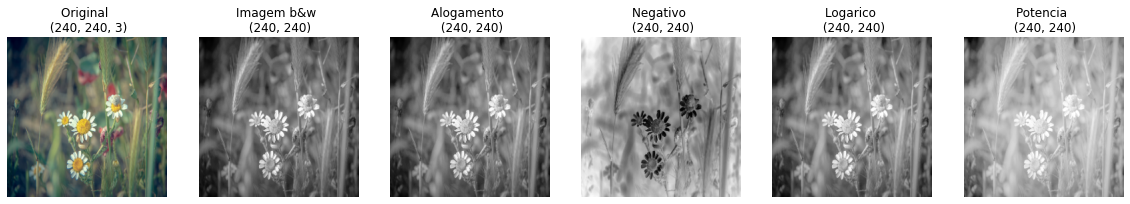

In [332]:
showAplicadas(img_red2, img_bw2, nova_alon, nova_neg, nova_log, nova_pot)

### Alongamento

In [313]:
for i in tqdm(range(1, 4)): 
    pasta = f"./dataset/alongamento/teste_{i+1}/"
    for j in classes:
        pastaCerta = pasta+j+'/'
        montaImagens(dataset, j, pastaCerta, formula='alongamento', c=0, k=k[i], e=e[i], gama=0)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_6849/1227920903.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / ( 1 + ( ( k / r ) ** e ) )
100%|██████████| 3/3 [15:36<00:00, 312.03s/it]


### Negativo

In [320]:
for i in tqdm(range(0, 1)): 
    pasta = f"./dataset/negativo/teste_{i+1}/"
    for j in classes:
        pastaCerta = pasta+j+'/'
        montaImagens(dataset, j, pastaCerta, formula='negativo', c=0, k=0, e=0, gama=0)
        print(j)

negativo: 100%|██████████| 764/764 [00:43<00:00, 17.63it/s]


daisy


negativo: 100%|██████████| 1052/1052 [01:02<00:00, 16.74it/s]


dandelion


negativo: 100%|██████████| 784/784 [00:47<00:00, 16.63it/s]


rose


negativo: 100%|██████████| 733/733 [00:46<00:00, 15.77it/s]


sunflower


100%|██████████| 1/1 [04:20<00:00, 260.26s/it]

tulip


### Logaritmico

In [322]:
for i in tqdm(range(0, 4)): 
    pasta = f"./dataset/logaritmico/teste_{i+1}/"
    for j in classes:
        pastaCerta = pasta+j+'/'
        montaImagens(dataset, j, pastaCerta, formula='logaritmico', c=c[i], k=0, e=0, gama=0)
        print(j)

logaritmico: 100%|██████████| 764/764 [01:00<00:00, 12.69it/s]


daisy


logaritmico: 100%|██████████| 1052/1052 [01:25<00:00, 12.30it/s]


dandelion


logaritmico: 100%|██████████| 784/784 [00:59<00:00, 13.12it/s]


rose


logaritmico: 100%|██████████| 733/733 [00:58<00:00, 12.59it/s]


sunflower


 25%|██▌       | 1/4 [05:42<17:08, 342.91s/it]

tulip


logaritmico: 100%|██████████| 764/764 [00:59<00:00, 12.79it/s]


daisy


logaritmico: 100%|██████████| 1052/1052 [01:17<00:00, 13.66it/s]


dandelion


logaritmico: 100%|██████████| 784/784 [00:59<00:00, 13.13it/s]


rose


logaritmico: 100%|██████████| 733/733 [00:54<00:00, 13.44it/s]


sunflower


 50%|█████     | 2/4 [11:10<11:07, 333.79s/it]

tulip


logaritmico: 100%|██████████| 764/764 [00:59<00:00, 12.75it/s]


daisy


logaritmico: 100%|██████████| 1052/1052 [01:16<00:00, 13.73it/s]


dandelion


logaritmico: 100%|██████████| 784/784 [00:59<00:00, 13.22it/s]


rose


logaritmico: 100%|██████████| 733/733 [01:00<00:00, 12.19it/s]


sunflower


 75%|███████▌  | 3/4 [16:41<05:32, 332.73s/it]

tulip


logaritmico: 100%|██████████| 764/764 [00:59<00:00, 12.91it/s]


daisy


logaritmico: 100%|██████████| 1052/1052 [01:24<00:00, 12.42it/s]


dandelion


logaritmico: 100%|██████████| 784/784 [01:00<00:00, 12.92it/s]


rose


logaritmico: 100%|██████████| 733/733 [00:58<00:00, 12.61it/s]


sunflower


100%|██████████| 4/4 [22:19<00:00, 334.96s/it]

tulip


### Potência

In [323]:
for i in tqdm(range(0, 1)): 
    pasta = f"./dataset/potencia/teste_{i+1}/"
    for j in classes:
        pastaCerta = pasta+j+'/'
        montaImagens(dataset, j, pastaCerta, formula='potencia', c=c[i], k=0, e=0, gama=[i])
        print(j)

potencia: 100%|██████████| 764/764 [03:22<00:00,  3.78it/s]


daisy


potencia: 100%|██████████| 1052/1052 [04:11<00:00,  4.19it/s]


dandelion


potencia: 100%|██████████| 784/784 [02:42<00:00,  4.83it/s]


rose


potencia: 100%|██████████| 733/733 [02:38<00:00,  4.62it/s]


sunflower


 25%|██▌       | 1/4 [16:24<49:14, 984.95s/it]

tulip


potencia: 100%|██████████| 764/764 [02:52<00:00,  4.43it/s]


daisy


potencia: 100%|██████████| 1052/1052 [03:56<00:00,  4.45it/s]


dandelion


potencia: 100%|██████████| 784/784 [02:57<00:00,  4.41it/s]


rose


potencia: 100%|██████████| 733/733 [02:47<00:00,  4.38it/s]


sunflower


 50%|█████     | 2/4 [32:38<32:36, 978.19s/it]

tulip


potencia: 100%|██████████| 764/764 [02:46<00:00,  4.58it/s]


daisy


potencia: 100%|██████████| 1052/1052 [03:52<00:00,  4.53it/s]


dandelion


potencia: 100%|██████████| 784/784 [02:55<00:00,  4.47it/s]


rose


potencia: 100%|██████████| 733/733 [02:48<00:00,  4.35it/s]


sunflower


 75%|███████▌  | 3/4 [48:43<16:12, 972.21s/it]

tulip


potencia: 100%|██████████| 764/764 [02:49<00:00,  4.52it/s]


daisy


potencia: 100%|██████████| 1052/1052 [03:53<00:00,  4.50it/s]


dandelion


potencia: 100%|██████████| 784/784 [02:53<00:00,  4.53it/s]


rose


potencia: 100%|██████████| 733/733 [02:45<00:00,  4.44it/s]


sunflower


100%|██████████| 4/4 [1:04:48<00:00, 972.14s/it]

tulip


In [340]:
for i in tqdm(range(0, 1)): 
    pasta = f"./teste_1/"
    for j in classes:
        pastaCerta = pasta+j+'/'
        montaImagens(dataset, j, pastaCerta, formula='potencia', c=c[0], k=0, e=0, gama=[1])
        print(j)

potencia: 100%|██████████| 764/764 [03:17<00:00,  3.86it/s]


daisy


potencia: 100%|██████████| 1052/1052 [04:54<00:00,  3.57it/s]


dandelion


potencia: 100%|██████████| 784/784 [03:39<00:00,  3.57it/s]


rose


potencia: 100%|██████████| 733/733 [03:27<00:00,  3.53it/s]


sunflower


100%|██████████| 1/1 [19:54<00:00, 1194.49s/it]

tulip


0.273